# Notebook 02, v2: Обучение многоканальной модели VAE

### Введение

Этот ноутбук является вторым этапом нашего усовершенствованного проекта. Здесь мы будем использовать высококачественный, многоканальный (I, Q, U) и аугментированный набор данных, созданный в предыдущем ноутбуке, для обучения более мощной и чувствительной модели Variational Autoencoder (VAE).

Цель остаётся прежней: научить модель "понимать", как выглядит "нормальный" участок реликтового излучения. Однако, работая с трёхканальными данными, модель теперь будет учиться не просто распознавать узоры, а понимать сложные **взаимосвязи** между температурой и поляризацией. Это должно позволить ей находить более тонкие и интересные аномалии.

### Шаг 0: Быстрый старт (Восстановление после перезапуска)

Эта ячейка предназначена для быстрого восстановления рабочего состояния после перезапуска среды выполнения. Она выполняет все необходимые подготовительные шаги:
1.  Настраивает среду и импортирует библиотеки.
2.  Готовит конвейер данных из нашего файла `.tfrecord`.
3.  Воссоздаёт архитектуру нашей модели VAE.
4.  Загружает финальные, **полностью обученные веса** из файлов `.keras`, сохранённых в конце предыдущей сессии.

После выполнения этой ячейки можно сразу переходить к шагам визуальной оценки (Шаг 5) и анализа, пропуская долгое обучение.

In [ ]:
# --- 1. Настройка среды ---
print("Настройка среды...")
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt
print("Библиотеки импортированы.")

# --- 2. Определение путей ---
project_path = '/content/drive/My Drive/CosmicLegacy'
data_path = os.path.join(project_path, 'data')
model_path = os.path.join(project_path, 'models_v2')

# --- 3. Подготовка конвейера данных ---
print("\nПодготовка конвейера данных для патчей...")
def _parse_function(example_proto):
    feature_description = {'patch': tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example_proto, feature_description)
    patch_tensor = tf.io.parse_tensor(example['patch'], out_type=tf.float32)
    patch_tensor = tf.reshape(patch_tensor, [32, 32, 3])
    return patch_tensor

final_filename = "cmb_patches_dataset_final.tfrecord"
final_filepath = os.path.join(data_path, final_filename)
if os.path.exists(final_filepath):
    raw_dataset = tf.data.TFRecordDataset(final_filepath)
    dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1024).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
    print(" -> Датасет готов к использованию.")
else:
    print(f" -> ОШИБКА: Файл с датасетом не найден.")
    dataset = None

# --- 4. Воссоздание архитектуры и загрузка обученных весов ---
print("\nВоссоздание архитектуры модели...")
# Гиперпараметры ДОЛЖНЫ совпадать с обученной моделью
input_shape = (32, 32, 3)
latent_dim = 16

# Энкодер
encoder_inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = models.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Слой сэмплирования
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Декодер
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

# Собираем VAE, чтобы иметь доступ к .encoder и .decoder
# (Этот класс VAE нужен только для структуры, мы не будем его обучать)
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
vae = VAE(encoder, decoder)
print(" -> Архитектура модели успешно воссоздана.")

# --- 5. Загрузка финальных весов ---
print("\nЗагрузка финальных обученных весов...")
encoder_path = os.path.join(model_path, 'final_encoder.keras')
decoder_path = os.path.join(model_path, 'final_decoder.keras')
try:
    # Загружаем веса в наши созданные модели
    vae.encoder.load_weights(encoder_path)
    vae.decoder.load_weights(decoder_path)
    print(" -> Веса энкодера и декодера успешно загружены.")
except Exception as e:
    print(f" -> ОШИБКА при загрузке весов: {e}")

print("\n--- Быстрый старт завершён. Можно переходить к Шагу 5. ---")

Настройка среды...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Библиотеки импортированы.

Подготовка конвейера данных для патчей...
 -> Датасет готов к использованию.

Воссоздание архитектуры модели...
 -> Архитектура модели успешно воссоздана.

Загрузка финальных обученных весов...
 -> ОШИБКА при загрузке весов: [Errno 2] No such file or directory: '/content/drive/My Drive/CosmicLegacy/models_v2/final_encoder.keras'

--- Быстрый старт завершён. Можно переходить к Шагу 5. ---


### Шаг 1: Настройка среды

Мы начинаем с настройки нашей рабочей среды. Мы монтируем Google Drive, определяем пути к файлам и импортируем все необходимые библиотеки, главной из которых является TensorFlow.

In [1]:
# --- 1. Настройка среды ---
print("Настройка среды...")
# Монтируем Google Drive для доступа к файлам проекта.
from google.colab import drive
drive.mount('/content/drive')

# Импортируем все необходимые библиотеки.
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt
print("Библиотеки импортированы.")

# --- 2. Определение путей ---
project_path = '/content/drive/My Drive/CosmicLegacy'
data_path = os.path.join(project_path, 'data')
model_path = os.path.join(project_path, 'models_v2') # Используем новую папку для новых моделей
os.makedirs(model_path, exist_ok=True)

print(f"Путь к проекту: {project_path}")
print(f"Путь к данным: {data_path}")
print(f"Модели будут сохраняться в: {model_path}")

Настройка среды...
Mounted at /content/drive
Библиотеки импортированы.
Путь к проекту: /content/drive/My Drive/CosmicLegacy
Путь к данным: /content/drive/My Drive/CosmicLegacy/data
Модели будут сохраняться в: /content/drive/My Drive/CosmicLegacy/models_v2


### Шаг 2: Загрузка и подготовка датасета

На этом шаге мы загружаем наши артефакты из `Notebook 01`:
1.  **Файл статистики `.json`:** Он содержит min/max значения для каждого канала, которые нам могут понадобиться.
2.  **Файл данных `.tfrecord`:** Это наш основной набор данных. Мы создадим из него высокопроизводительный конвейер данных `tf.data.Dataset`, который будет эффективно подавать патчи в модель во время обучения.

Ключевые операции с датасетом:
* **Парсинг:** Преобразование бинарных данных из файла обратно в изображения.
* **Перемешивание (`shuffle`):** Перемешивание данных для более качественного обучения.
* **Разбиение на батчи (`batch`):** Группировка данных в порции (батчи) для подачи в нейросеть.
* **Предварительная загрузка (`prefetch`):** Оптимизация, которая позволяет GPU не простаивать в ожидании данных от CPU.

 Ключевое изменение в этой версии — мы добавляем метод `.repeat()` в наш конвейер данных. Это превращает наш конечный набор данных в "бесконечный" поток, который может непрерывно подавать данные в модель на протяжении всех эпох обучения.

In [2]:
# --- 1. Загрузка статистики для нормализации ---
print("Загрузка статистики для нормализации...")
stats_filepath = os.path.join(data_path, "normalization_stats_3_channel.json")
try:
    with open(stats_filepath, 'r') as f:
        normalization_stats = json.load(f)
    print(" -> Статистика для нормализации успешно загружена.")
except FileNotFoundError:
    print(f" -> ОШИБКА: Файл со статистикой не найден.")
    normalization_stats = None

# --- 2. Подготовка конвейера данных из TFRecord ---
print("\nПодготовка конвейера данных для патчей...")

# Вспомогательная функция для "расшифровки" записей из файла.
def _parse_function(example_proto):
    feature_description = {'patch': tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example_proto, feature_description)
    patch_tensor = tf.io.parse_tensor(example['patch'], out_type=tf.float32)
    patch_tensor = tf.reshape(patch_tensor, [32, 32, 3])
    return patch_tensor

final_filename = "cmb_patches_dataset_final.tfrecord"
final_filepath = os.path.join(data_path, final_filename)

if os.path.exists(final_filepath):
    raw_dataset = tf.data.TFRecordDataset(final_filepath)
    dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

    # --- 3. Финальная подготовка датасета для обучения ---
    BATCH_SIZE = 64

    # --- КРИТИЧЕСКОЕ ИСПРАВЛЕНИЕ: Добавляем .repeat() ---
    # .repeat() заставляет датасет начинаться заново после того, как он закончится.
    dataset = dataset.repeat()

    # Перемешиваем данные.
    dataset = dataset.shuffle(buffer_size=1024)
    # Группируем данные в батчи.
    dataset = dataset.batch(BATCH_SIZE)
    # Включаем предварительную загрузку для повышения производительности.
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    print(f" -> Датасет готов к использованию. Размер батча: {BATCH_SIZE}")
else:
    print(f" -> ОШИБКА: Файл с датасетом не найден.")
    dataset = None

Загрузка статистики для нормализации...
 -> Статистика для нормализации успешно загружена.

Подготовка конвейера данных для патчей...
 -> Датасет готов к использованию. Размер батча: 64


### Шаг 2.1: Визуальная проверка загруженных данных

Прежде чем приступить к созданию модели, давайте выполним быструю визуальную проверку, чтобы убедиться, что наш конвейер данных работает корректно. Мы возьмём один батч из нашего `dataset` и отобразим несколько патчей из него. Это подтвердит, что данные успешно считываются, парсятся и имеют правильную форму и содержание.

Отображение одного батча данных для проверки...


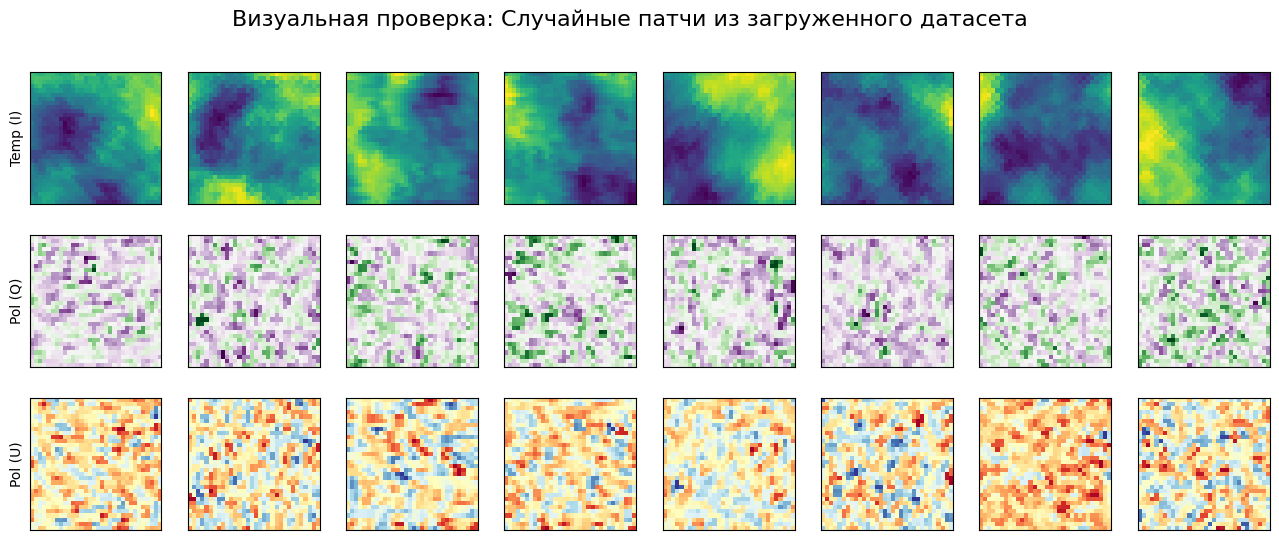

In [3]:
if 'dataset' in locals() and dataset is not None:
    print("Отображение одного батча данных для проверки...")

    # Берём один батч из нашего датасета.
    sample_batch = next(iter(dataset))

    # Определяем, сколько примеров показать (не больше 8).
    num_examples_to_show = min(sample_batch.shape[0], 8)

    plt.figure(figsize=(16, 6))
    plt.suptitle("Визуальная проверка: Случайные патчи из загруженного датасета", fontsize=16)

    for i in range(num_examples_to_show):
        # Отображаем i-й патч из батча.
        patch = sample_batch[i]

        # Канал I (Температура)
        plt.subplot(3, num_examples_to_show, i + 1)
        plt.imshow(patch[:, :, 0], cmap='viridis')
        if i == 0: plt.ylabel("Temp (I)")
        plt.xticks([]); plt.yticks([])

        # Канал Q (Поляризация)
        plt.subplot(3, num_examples_to_show, i + 1 + num_examples_to_show)
        plt.imshow(patch[:, :, 1], cmap='PRGn')
        if i == 0: plt.ylabel("Pol (Q)")
        plt.xticks([]); plt.yticks([])

        # Канал U (Поляризация)
        plt.subplot(3, num_examples_to_show, i + 1 + 2*num_examples_to_show)
        plt.imshow(patch[:, :, 2], cmap='RdYlBu_r')
        if i == 0: plt.ylabel("Pol (U)")
        plt.xticks([]); plt.yticks([])

    plt.show()
else:
    print("Датасет не был загружен. Проверка невозможна.")

### Шаг 3: Создание многоканальной модели VAE

Теперь мы создаём архитектуру нашего нового Вариационного Автоэнкодера. Она будет очень похожа на последнюю рабочую версию из нашего первого эксперимента, но с одним ключевым отличием: **входной слой теперь рассчитан на приём трёхканальных изображений** (`32x32x3`).

Это означает, что модель будет одновременно анализировать данные о Температуре (I), Поляризации (Q) и Поляризации (U), что позволит ей выучить сложные взаимосвязи между этими физическими величинами.

Мы сохраняем все удачные решения из предыдущей итерации:
* **Мощная архитектура:** Глубокие энкодер и декодер с достаточным количеством фильтров.
* **MSE Loss:** Использование среднеквадратичной ошибки для корректного сравнения изображений.
* **Beta-VAE:** Применение весового коэффициента `kl_beta` для сбалансированного обучения.

Эта версия модели включает в себя ключевое улучшение, направленное на решение проблемы плохой реконструкции каналов поляризации (Q и U). Мы вводим **весовую функцию потерь**.

Поскольку сигнал в канале температуры (I) значительно сильнее, чем в каналах поляризации, стандартная функция потерь заставляет модель фокусироваться в основном на канале I. Чтобы сбалансировать этот эффект, мы будем вычислять ошибку реконструкции для каждого из трёх каналов отдельно и затем суммировать их с разными весовыми коэффициентами. Мы придадим больший "вес" ошибкам в каналах Q и U, заставляя модель уделять им столько же внимания, сколько и каналу температуры.

In [4]:
if 'dataset' in locals() and dataset is not None:
    # --- Гиперпараметры (без изменений) ---
    input_shape = (32, 32, 3)
    latent_dim = 16

    # --- Архитектура Энкодера и Декодера (без изменений) ---
    encoder_inputs = layers.Input(shape=input_shape, name="encoder_input")
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    encoder = models.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
    # --- ВОЗВРАЩАЕМ ОТОБРАЖЕНИЕ ТАБЛИЦЫ ---
    encoder.summary()

    class Sampling(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    latent_inputs = layers.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(4 * 4 * 128, activation="relu")(latent_inputs)
    x = layers.Reshape((4, 4, 128))(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
    decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")
    # --- ВОЗВРАЩАЕМ ОТОБРАЖЕНИЕ ТАБЛИЦЫ ---
    decoder.summary()


    # --- Финальная модель VAE с ВЕСОВОЙ функцией потерь ---
    class VAE(models.Model):
        def __init__(self, encoder, decoder, kl_beta=1.0, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.kl_beta = kl_beta
            self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
            self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z_mean, z_log_var = self.encoder(data)
                z = Sampling()([z_mean, z_log_var])
                reconstruction = self.decoder(z)

                reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()

                loss_i = reconstruction_loss_fn(data[:, :, :, 0], reconstruction[:, :, :, 0])
                loss_q = reconstruction_loss_fn(data[:, :, :, 1], reconstruction[:, :, :, 1])
                loss_u = reconstruction_loss_fn(data[:, :, :, 2], reconstruction[:, :, :, 2])

                weight_i = 1.0
                weight_q = 2.0
                weight_u = 2.0

                reconstruction_loss = (weight_i * loss_i) + (weight_q * loss_q) + (weight_u * loss_u)
                reconstruction_loss *= input_shape[0] * input_shape[1]

                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
                total_loss = reconstruction_loss + self.kl_beta * kl_loss

            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(), "kl_loss": self.kl_loss_tracker.result()}

    # Создаём финальную модель VAE.
    vae = VAE(encoder, decoder, kl_beta=0.1)
    print("\nМногоканальная модель VAE с весовой функцией потерь успешно создана.")

else:
    print("Датасет не загружен. Пожалуйста, сначала запустите предыдущие шаги.")

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      2,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      2,064 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 359,648 (1.37 MB)

 Trainable params: 359,648 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,523 (1.05 MB)

 Trainable params: 275,523 (1.05 MB)

 Non-trainable params: 0 (0.00 B)


Многоканальная модель VAE с весовой функцией потерь успешно создана.


### Шаг 4: Компиляция и обучение модели с сохранением прогресса

Теперь, когда архитектура модели определена, мы "оживим" её, запустив процесс обучения. Этот процесс будет устойчив к сбоям благодаря механизму **сохранения контрольных точек (checkpointing)**.

1.  **Проверка контрольной точки:** Перед началом обучения скрипт проверит, существует ли на диске файл с ранее сохранённым прогрессом. Если да, он загрузит веса в модель, и обучение продолжится с того места, где оно было прервано.
2.  **Компиляция:** Мы "компилируем" модель, назначая ей оптимизатор `Adam`. Оптимизатор — это алгоритм, который модель использует для минимизации своей ошибки.
3.  **Обучение (`fit`):** Мы запускаем главный цикл обучения. Модель будет многократно "смотреть" на батчи из нашего датасета на протяжении заданного числа эпох.
4.  **Callback `ModelCheckpoint`:** Специальный "наблюдатель" будет автоматически сохранять веса модели на диск после каждой эпохи. Это гарантирует, что мы не потеряем прогресс, даже если сессия Colab прервётся.
5.  **Визуализация:** После завершения обучения мы построим график кривых потерь, чтобы визуально оценить, насколько успешно прошло обучение.

Ключевое исправление в этой версии — мы явно "строим" модель с помощью `vae.build()` перед вызовом `.fit()`. Это гарантирует, что все слои модели полностью инициализированы, что предотвращает ошибки при сохранении контрольных точек.

Эта версия исправляет критическую проблему с "амнезией" оптимизатора при возобновлении обучения. Мы изменяем наш механизм сохранения контрольных точек, чтобы он сохранял **всю модель целиком** (включая её архитектуру, веса и состояние оптимизатора) в один файл формата `.keras`.

Это гарантирует, что при повторном запуске обучение будет возобновлено в точности с того места, где оно было прервано, сохраняя плавность и стабильность процесса.

In [5]:
# Импортируем наш новый callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

if 'vae' in locals() and 'dataset' in locals() and dataset is not None:
    # --- 1. Настройка сохранения прогресса (Checkpoints) ---
    checkpoint_path = os.path.join(model_path, "training_v2_checkpoint.keras")
    print(f"Файл для сохранения полной модели: {checkpoint_path}")

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=False,
        verbose=1,
        save_freq='epoch',
        # Добавляем monitor, чтобы сохранять только лучшую модель
        monitor='reconstruction_loss',
        mode='min',
        save_best_only=True
    )

    # --- 2. Настройка ReduceLROnPlateau ---
    # Этот callback будет уменьшать скорость обучения, если ошибка не улучшается.
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='reconstruction_loss', # Следим за ошибкой реконструкции
        factor=0.5,      # Уменьшаем скорость обучения в 2 раза (0.5)
        patience=5,      # Ждём 5 эпох без улучшений, прежде чем уменьшить
        min_lr=1e-6,     # Минимальная скорость обучения
        verbose=1
    )

    # --- 3. Компиляция и построение модели ---
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    vae.build((None,) + input_shape)

    # --- 4. Проверка и загрузка существующего прогресса ---
    if os.path.exists(checkpoint_path):
        print("\nНайден файл с полной моделью. Загрузка...")
        try:
            vae = tf.keras.models.load_model(checkpoint_path, custom_objects={'VAE': VAE, 'Sampling': Sampling})
            print(" -> Полная модель (включая оптимизатор) успешно загружена.")
        except Exception as e:
            print(f" -> ОШИБКА при загрузке модели: {e}. Обучение начнётся с нуля.")
    else:
        print("\nФайл с прогрессом не найден. Обучение начнётся с нуля.")

    # --- 5. Запуск обучения ---
    total_patches = 40000
    steps_per_epoch = total_patches // BATCH_SIZE

    print("\nЗапуск обучения модели...")
    history = vae.fit(
        dataset,
        epochs=75,
        steps_per_epoch=steps_per_epoch,
        # Передаём ОБА наших callback'а
        callbacks=[checkpoint_callback, reduce_lr_callback]
    )
    print("Обучение модели завершено.")

    # --- 6. Визуализация истории обучения ---
    print("\nПостроение графика истории обучения...")
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['reconstruction_loss'], label='Ошибка реконструкции (MSE)')
    plt.plot(history.history['kl_loss'], label='KL Loss')
    plt.title('История обучения многоканальной VAE')
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка (Логарифмическая шкала)')
    plt.legend()
    plt.grid(True)
    plt.yscale('log') # Используем логарифмическую шкалу для наглядности
    plt.show()

else:
    print("Модель или датасет не найдены. Пожалуйста, сначала запустите предыдущие шаги.")


Файл для сохранения полной модели: /content/drive/My Drive/CosmicLegacy/models_v2/training_v2_checkpoint.keras

Файл с прогрессом не найден. Обучение начнётся с нуля.

Запуск обучения модели...
Epoch 1/75
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 0.0021 - loss: 32.2777 - reconstruction_loss: 32.2775
Epoch 1: reconstruction_loss improved from inf to 32.17201, saving model to /content/drive/My Drive/CosmicLegacy/models_v2/training_v2_checkpoint.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - kl_loss: 0.0021 - loss: 32.2763 - reconstruction_loss: 32.2761 - learning_rate: 0.0010
Epoch 2/75
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 6.7495e-07 - loss: 31.9094 - reconstruction_loss: 31.9094
Epoch 2: reconstruction_loss improved from 32.17201 to 32.06183, saving model to /content/drive/My Drive/CosmicLegacy/models_v2/training_v2_checkpoint.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 6.7456e-07 - loss: 31.9099 - reconstruction_loss: 31.9099 - learning_rate:

Отображение оригинальных и восстановленных патчей для всех каналов...


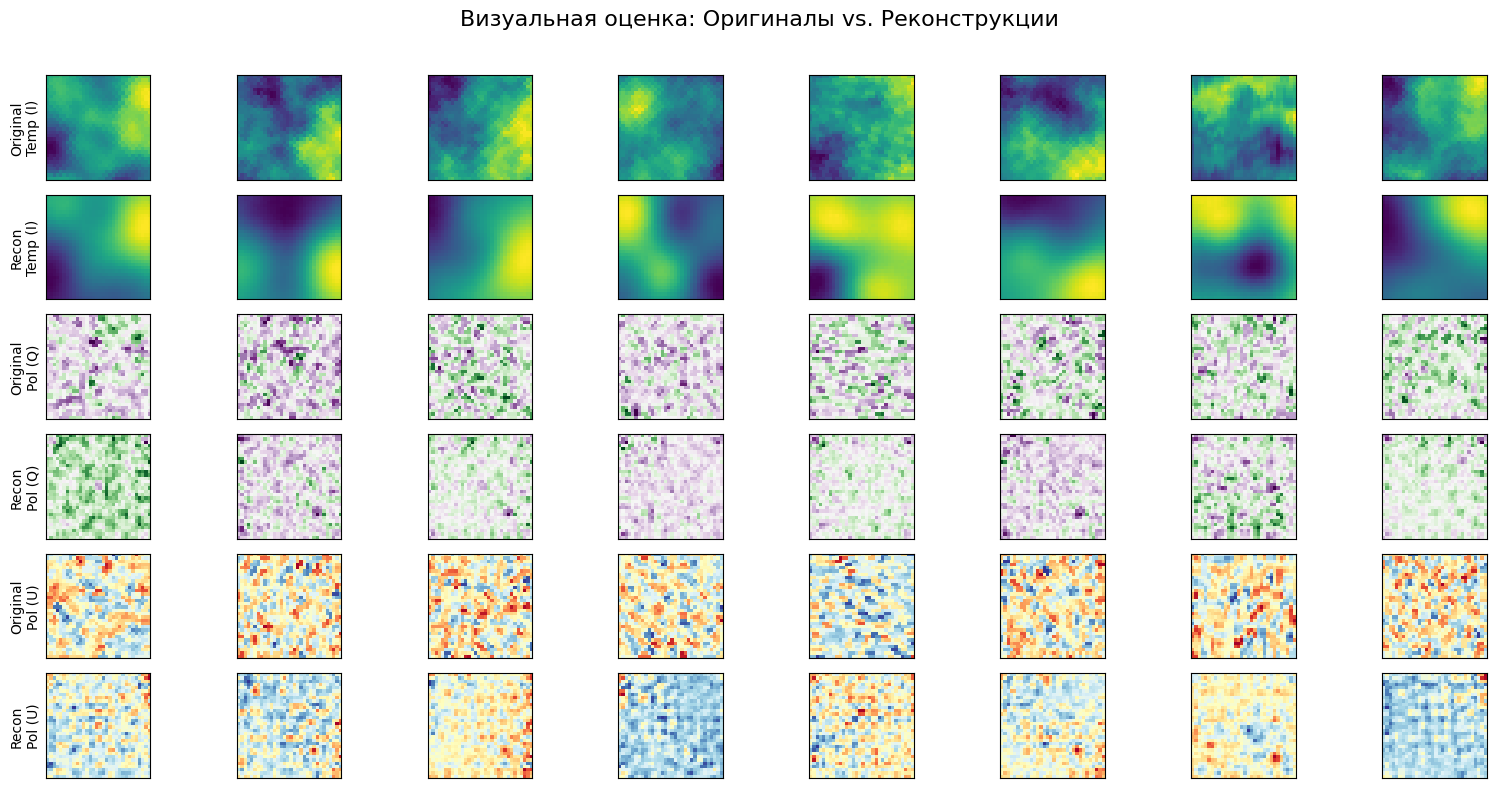

In [7]:
if 'vae' in locals() and 'dataset' in locals() and dataset is not None:
    # --- 1. Берём один батч данных для теста ---
    sample_batch = next(iter(dataset))

    # Определяем, сколько примеров показать (не больше 8).
    num_examples_to_show = min(sample_batch.shape[0], 8)
    original_patches = sample_batch[:num_examples_to_show]

    # --- 2. Прогоняем патчи через VAE, чтобы получить реконструкции ---
    z_mean, z_log_var = vae.encoder.predict(original_patches, verbose=0)
    z = Sampling()([z_mean, z_log_var])
    reconstructed_patches = vae.decoder.predict(z, verbose=0)

    # --- 3. Отображаем результаты для всех трёх каналов ---
    print("Отображение оригинальных и восстановленных патчей для всех каналов...")

    # Создаём большую фигуру для отображения всех каналов.
    plt.figure(figsize=(16, 8))
    plt.suptitle("Визуальная оценка: Оригиналы vs. Реконструкции", fontsize=16)

    for i in range(num_examples_to_show):
        original_patch = original_patches[i]
        reconstructed_patch = reconstructed_patches[i]

        # --- Канал I (Температура) ---
        # Оригинал
        ax = plt.subplot(6, num_examples_to_show, i + 1)
        plt.imshow(original_patch[:, :, 0], cmap='viridis')
        if i == 0: plt.ylabel("Original\nTemp (I)")
        plt.xticks([]); plt.yticks([])

        # Реконструкция
        ax = plt.subplot(6, num_examples_to_show, i + 1 + num_examples_to_show)
        plt.imshow(reconstructed_patch[:, :, 0], cmap='viridis')
        if i == 0: plt.ylabel("Recon\nTemp (I)")
        plt.xticks([]); plt.yticks([])

        # --- Канал Q (Поляризация) ---
        # Оригинал
        ax = plt.subplot(6, num_examples_to_show, i + 1 + 2*num_examples_to_show)
        plt.imshow(original_patch[:, :, 1], cmap='PRGn')
        if i == 0: plt.ylabel("Original\nPol (Q)")
        plt.xticks([]); plt.yticks([])

        # Реконструкция
        ax = plt.subplot(6, num_examples_to_show, i + 1 + 3*num_examples_to_show)
        plt.imshow(reconstructed_patch[:, :, 1], cmap='PRGn')
        if i == 0: plt.ylabel("Recon\nPol (Q)")
        plt.xticks([]); plt.yticks([])

        # --- Канал U (Поляризация) ---
        # Оригинал
        ax = plt.subplot(6, num_examples_to_show, i + 1 + 4*num_examples_to_show)
        plt.imshow(original_patch[:, :, 2], cmap='RdYlBu_r')
        if i == 0: plt.ylabel("Original\nPol (U)")
        plt.xticks([]); plt.yticks([])

        # Реконструкция
        ax = plt.subplot(6, num_examples_to_show, i + 1 + 5*num_examples_to_show)
        plt.imshow(reconstructed_patch[:, :, 2], cmap='RdYlBu_r')
        if i == 0: plt.ylabel("Recon\nPol (U)")
        plt.xticks([]); plt.yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("Модель или датасет не найдены.")

### Шаг 6: Сохранение финальной обученной модели

Это последний шаг в этом ноутбуке. Мы сохраняем **всю модель целиком** (архитектуру, веса и состояние оптимизатора) в единый файл формата `.keras`.

Это самый надёжный способ сохранения, который гарантирует, что мы сможем в точности воссоздать модель в следующем ноутбуке для финального анализа. Мы сохраняем отдельно энкодер и декодер, так как для поиска аномалий нам в первую очередь понадобится именно энкодер.

In [17]:
if 'vae' in locals():
    # --- Определяем пути к файлам для сохранения моделей ---
    encoder_path = os.path.join(model_path, 'final_encoder.keras')
    decoder_path = os.path.join(model_path, 'final_decoder.keras')

    # --- Сохраняем модели ---
    # Метод .save() сохраняет всё необходимое.
    vae.encoder.save(encoder_path)
    vae.decoder.save(decoder_path)

    print(f"Энкодер сохранён в: {encoder_path}")
    print(f"Декодер сохранён в: {decoder_path}")
else:
    print("Модель VAE не найдена, сохранение невозможно.")

Энкодер сохранён в: /content/drive/My Drive/CosmicLegacy/models_v2/final_encoder.keras
Декодер сохранён в: /content/drive/My Drive/CosmicLegacy/models_v2/final_decoder.keras
